In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4
import statsmodels.api as sm
from scipy import stats

In [2]:
data = pd.read_csv(r'file:///C:\Users\puneet\Desktop\data%20analytics\bitcoin%20data.csv')

In [3]:
data.head(2)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.shape

(4857377, 8)

In [5]:
data.Timestamp = pd.to_datetime(data.Timestamp, unit = 's')
data.index = data.Timestamp
data = data.resample('D').mean()


In [6]:
data_month = data.resample('M').mean()
data_year = data.resample('Y').mean()
data_Q = data.resample('Q-DEC').mean()

In [7]:
data

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159
...,...,...,...,...,...,...,...
2021-03-27,55193.240643,55219.665031,55168.757372,55195.415367,1.823877,100884.732367,55193.357260
2021-03-28,55833.608471,55857.735342,55810.425126,55835.012863,1.447939,80632.115263,55832.958824
2021-03-29,56914.886595,56946.213593,56885.242967,56915.629993,3.732887,213754.555988,56913.993819


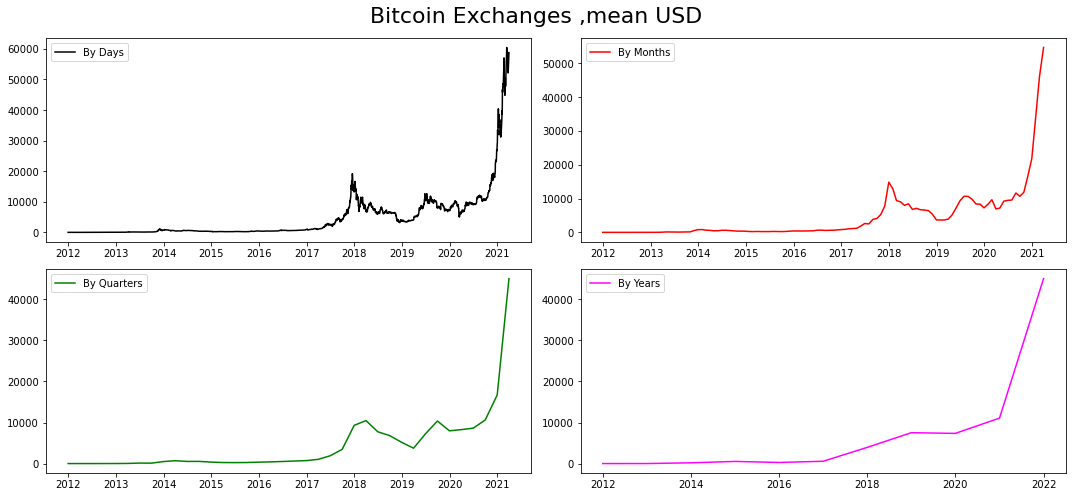

In [8]:
fig = plt.figure(figsize=[15,7])
plt.suptitle('Bitcoin Exchanges ,mean USD', fontsize = 22)

plt.subplot(221)
plt.plot(data.Weighted_Price, '-', label ='By Days', color = 'Black')
plt.legend()

plt.subplot(222)
plt.plot(data_month.Weighted_Price, '-', label ='By Months', color = 'red')
plt.legend()

plt.subplot(223)
plt.plot(data_Q.Weighted_Price, '-', label ='By Quarters', color = 'green')
plt.legend()

plt.subplot(224)
plt.plot(data_year.Weighted_Price, '-', label ='By Years', color = 'magenta')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
print('Dickey-Fuller test: p=%f' %sm.tsa.stattools.adfuller(data_month.Weighted_Price)[1])

Dickey-Fuller test: p=0.998863


its not stationary

In [10]:
# detrending and normal distribution conversion
data_month['Weighted_Price_box'],lmbda = stats.boxcox(data_month.Weighted_Price)
print('Dickey-Fuller test: p=%f' %sm.tsa.stattools.adfuller(data_month.Weighted_Price)[1])

Dickey-Fuller test: p=0.998863


In [12]:
#seasonal diff
data_month['prices_box_diff1'] = data_month.Weighted_Price_box - data_month.Weighted_Price_box.shift(12)
print('Dickey-Fuller test: p=%f' %sm.tsa.stattools.adfuller(data_month.prices_box_diff1[12:])[1])

Dickey-Fuller test: p=0.444282


In [13]:
#Regular differentiation
data_month['prices_box_diff2'] = data_month.prices_box_diff1 - data_month.prices_box_diff1.shift(1)
print('Dickey-Fuller test: p=%f' %sm.tsa.stattools.adfuller(data_month.prices_box_diff2[13:])[1])


Dickey-Fuller test: p=0.000024


<Figure size 360x360 with 0 Axes>

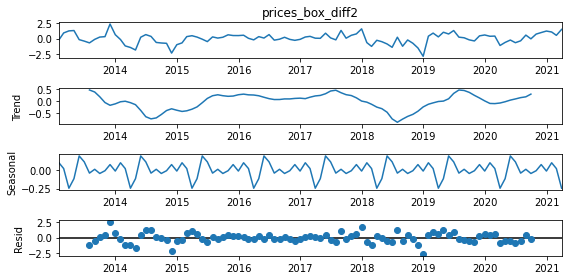

In [15]:
plt.figure(figsize=(5,5))
sm.tsa.seasonal_decompose(data_month.prices_box_diff2[13:]).plot()
plt.show()

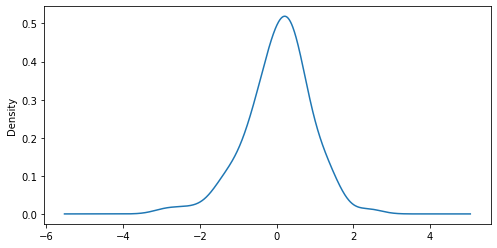

In [16]:
data_month.prices_box_diff2[13:].plot(kind = 'kde')
plt.show()

In [17]:
data_month.prices_box_diff2[13:].describe()

count    99.000000
mean      0.051077
std       0.843415
min      -2.885582
25%      -0.361817
50%       0.130387
75%       0.552975
max       2.404330
Name: prices_box_diff2, dtype: float64

ACF and PACF

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


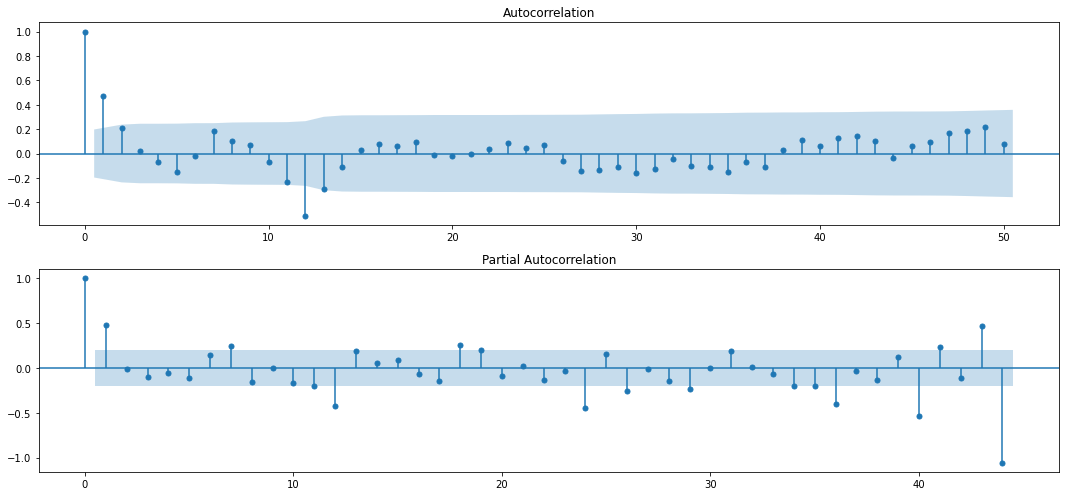

In [19]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig = plt.figure(figsize= (15,7))
ax = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(data_month.prices_box_diff2[13:].values.squeeze(), lags = 50,ax= ax)
ax = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_month.prices_box_diff2[13:].values.squeeze(),lags = 44, ax= ax)
plt.tight_layout()
plt.show()

We will apply SARIMAX(p,q,P,Q)(12) model as it has seasonality also, its not completely removed

In [21]:
from itertools import product
#initial approximation of parameters
Qs= range(0,3)
qs= range(0,3)
Ps= range(0,3)
ps= range(0,3)
D=1
d=1
parameters = product(Qs, qs, Ps,ps)
parameters_list = list(parameters)
len(parameters_list)

81

In [23]:
import warnings
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list :
    try:
        model = sm.tsa.statespace.SARIMAX(data_month.prices_box_diff2, order=(param[0],d,param[1]),
                                         seasonal_order =(param[2],D,param[3],12) ).fit(disp=-1)
    except ValueError:
        print('wrong parameter :' ,param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param,model.aic])

In [24]:
#best models
result_table = pd.DataFrame(results)
result_table.columns = ['Parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending = True).head(10))
print(best_model.summary())

      Parameters         aic
38  (1, 1, 0, 2)  416.846587
41  (1, 1, 1, 2)  417.911249
20  (0, 2, 0, 2)  418.308130
23  (0, 2, 1, 2)  418.726102
65  (2, 1, 0, 2)  418.738300
47  (1, 2, 0, 2)  418.748276
44  (1, 1, 2, 2)  419.392086
43  (1, 1, 2, 1)  419.591881
50  (1, 2, 1, 2)  419.891287
74  (2, 2, 0, 2)  420.211779
                                        SARIMAX Results                                        
Dep. Variable:                        prices_box_diff2   No. Observations:                  112
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                -203.423
Date:                                 Fri, 25 Jun 2021   AIC                            416.847
Time:                                         19:02:09   BIC                            429.822
Sample:                                     12-31-2011   HQIC                           422.097
                                          - 03-31-2021                                         
Covarianc

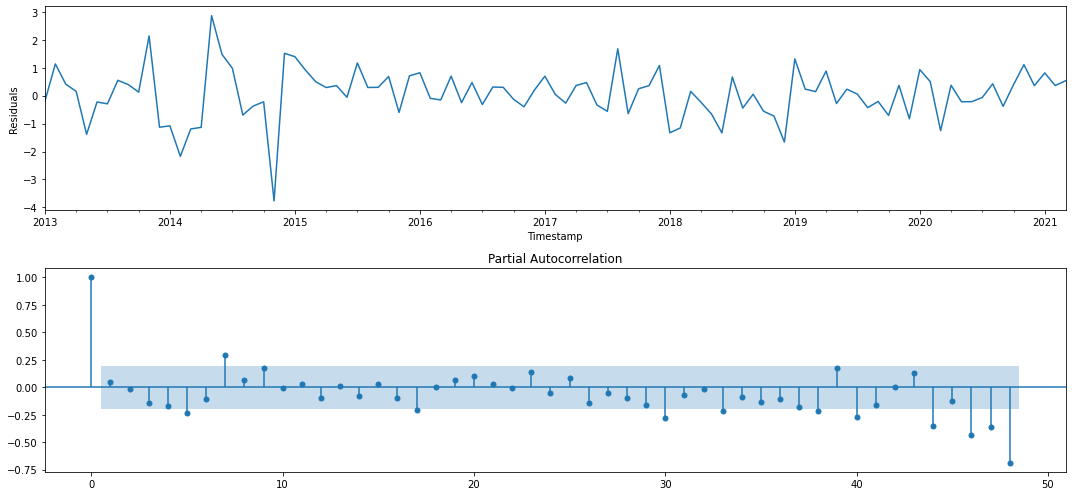

In [25]:
#analysis of residuals
plt.figure(figsize= (15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(best_model.resid[13:].values.squeeze(), lags = 48,ax= ax)
plt.tight_layout()
plt.show()

#pacf : measure is difference of first lag and prediction
#acf : measure is difference b/w any longer lag and prediction - 12  seasonal period

In [26]:
import statsmodels.api as sm
sm.stats.durbin_watson(best_model.resid[13:].values)

1.891104299483156

In [27]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(best_model.resid[13:], lags = 6)

(array([ 0.24174729,  0.25093984,  2.16617716,  5.21808296, 10.41454468,
        10.96836012]),
 array([0.62294697, 0.8820823 , 0.5386411 , 0.26564372, 0.0643061 ,
        0.08935924]))

<AxesSubplot:ylabel='Density'>

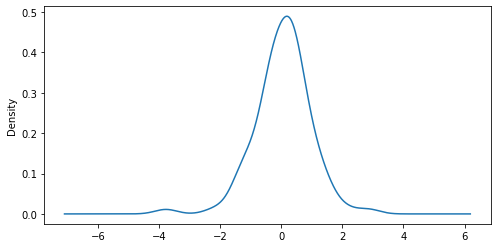

In [28]:
best_model.resid.plot(kind = 'kde')